# Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, random_split
from urllib.request import urlretrieve
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Models

## UNet

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # todo
        # Hint: Do not use ReLU in last convolutional set of up-path (128-64-64) for stability reasons!
        self.downStep1 = downStep(3, 64, firstLayer=True)
        self.downStep2 = downStep(64, 128)
        self.downStep3 = downStep(128, 256)
        self.downStep4 = downStep(256, 512)
        self.downStep5 = downStep(512, 1024)

        self.upStep1 = upStep(1024, 512)
        self.upStep2 = upStep(512, 256)
        self.upStep3 = upStep(256, 128)
        self.upStep4 = upStep(128, 64)

        self.conv = nn.Conv2d(64, 3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # todo
        x1 = self.downStep1(x)
        # print('x1', x1.shape)
        x2 = self.downStep2(x1)
        # print('x2', x2.shape)
        x3 = self.downStep3(x2)
        # print('x3', x3.shape)
        x4 = self.downStep4(x3)
        # print('x4', x4.shape)
        x5 = self.downStep5(x4)
        # print('x5', x5.shape)

        x = self.upStep1(x5, x4)
        # print(x.shape)
        x = self.upStep2(x, x3)
        # print(x.shape)
        x = self.upStep3(x, x2)
        # print(x.shape)
        x = self.upStep4(x, x1)
        # print(x.shape)

        x = self.conv(x)
        # print(x.shape)
        x = self.sigmoid(x)

        return x

class downStep(nn.Module):
    def __init__(self, inC, outC, firstLayer=False):
        super(downStep, self).__init__()
        # todo
        self.firstLayer = firstLayer

        self.conv = nn.Sequential(
            nn.Conv2d(inC, outC, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(outC, outC, 3, padding=1),
            nn.ReLU())

        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        # todo
        if not self.firstLayer:
            x = self.maxpool(x)

        x = self.conv(x)

        return x

class upStep(nn.Module):
    def __init__(self, inC, outC):
        super(upStep, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(inC, outC, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(outC, outC, 3, padding=1),
            nn.ReLU())

        self.upsampling = nn.ConvTranspose2d(inC, outC, 2, 2)

    def forward(self, x, x_down):
        # todo
        x = self.upsampling(x)

        x = torch.cat([x_down, x], dim=1)

        x = self.conv(x)

        return x

# Datasets

## Abstract class

In [3]:
class MaskImageDataset:
    """
    Basic class to download clean images and generate masks.
    """

    def __init__(self, from_file=None):
        """
        Load dataset from file if specified.
        Otherwise automaticly download and create from scratch.
        """

        if not from_file is None:
            self.load_dataset(from_file)
            return
        # Load some images
        self.images = self.load_images()
        # Add masks to images
        self.masked_images = torch.cat(
            [self.mask_image(image).unsqueeze(0) for image in self.images]
            , dim=0)

    def load_images(self) -> torch.Tensor:
        """
        Load image from the internet.
        """
        return torch.tensor([])

    def mask_image(self, image: torch.Tensor) -> torch.Tensor:
        """
        Create a mask for image.
        """
        return image

    def get_image(self, index):
        """
        Give image by index.
        """
        return self.images[index]

    def get_masked_image(self, index):
        """
        Give image with mask by index.
        """
        return self.masked_images[index]

    def save_dataset(self, filename="dataset.pt"):
        """
        Save any dataset to a file.
        """
        torch.save({
            "images": self.images,
            "masked_images": self.masked_images
        }, filename)

    def load_dataset(self, filename="dataset.pt"):
        """
        Load a dataset from a file.
        """
        dataset = torch.load(filename)
        self.images = dataset["images"]
        self.masked_images = dataset["masked_images"]

    def pack_to_dataloaders(self, batch_size=32, train_fraction=0.7) -> tuple[DataLoader, DataLoader]:
        """
        Pack image data into dataloaders for model training.
        """
        images_dataset = TensorDataset(self.masked_images, self.images)
        images_train, images_val = random_split(images_dataset, [train_fraction, 1-train_fraction])
        return (DataLoader(images_train, batch_size=batch_size, shuffle=False),
                DataLoader(images_val, batch_size=batch_size, shuffle=True))

    def __len__(self):
        return self.images.shape[0]


## CIFAR10

In [4]:
class CIFAR10Masked(MaskImageDataset):
    """
    CIFAR10 dataset with 32x32 RGB images.
    """

    def load_images(self) -> np.array:
        # Load images using keras
        (images1, _), (images2, _) = tf.keras.datasets.cifar10.load_data()
        torch_data = torch.cat((torch.tensor(images1, dtype=torch.float32)/255, torch.tensor(images2, dtype=torch.float32)/255), dim=0)
        return torch_data.permute((0, 3, 1, 2))

    def mask_image(self, image: torch.Tensor) -> np.array:
        image = image.permute((1, 2, 0))
        # Generate random top-left coordinates.
        x1, y1 = np.random.randint(0, 26, size=2)
        # Generate random bottom-right coordinates
        min_w, min_h, max_w, max_h = 5, 5, 9, 9
        x2 = np.random.randint(min(x1+min_w,32), min(x1+max_w,32))
        y2 = np.random.randint(min(y1+min_h,32), min(y1+max_h,32))
        # Copy original image
        masked_image = image.clone().detach()
        # Fill black rectange on generated coordinates
        mask = torch.tensor(np.zeros((y2-y1)*(x2-x1)*3).reshape(y2-y1,x2-x1,3))
        masked_image[y1:y2,x1:x2] = mask
        # Return result
        return masked_image.permute((2, 0, 1))

170498071/170498071 [==============================] - 4s 0us/step


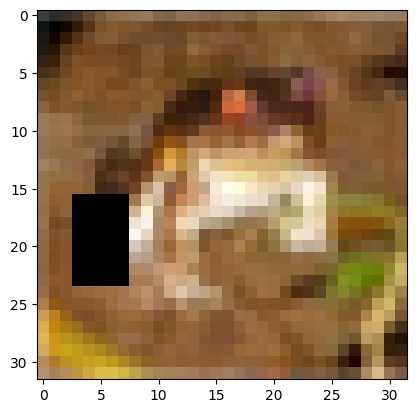

In [6]:
# Test for CIFAR10
cifar10_test = CIFAR10Masked()
train_loader, test_loader = cifar10_test.pack_to_dataloaders(batch_size=64)
cifar10_test.save_dataset(filename="cifar10.pt")
plt.imshow(cifar10_test.get_masked_image(0).permute((1, 2, 0)))

## stl10

In [34]:
import tensorflow_datasets as tfds

class STL10Masked(MaskImageDataset):
    """
    STL10 dataset with 96x96 RGB images.
    """

    def load_images(self) -> np.array:
        # Load images using tensorflow
        images = tfds.load('stl10',
                        split='train',
                        #split=['train', 'test'],
                        data_dir="/content/dataset")
        torch_data = torch.tensor([img['image'].numpy()/255 for img in images], dtype=torch.float32)
        # torch_data = torch.tensor(images, dtype=torch.float32)/255
        return torch_data.permute((0, 3, 1, 2))

    def mask_image(self, image: torch.Tensor) -> np.array:
        image = image.permute((1, 2, 0))
        # Generate random top-left coordinates.
        x1, y1 = np.random.randint(0, 26, size=2)
        # Generate random bottom-right coordinates
        min_w, min_h, max_w, max_h = 10, 10, 27, 27
        x2 = np.random.randint(min(x1+min_w,96), min(x1+max_w,96))
        y2 = np.random.randint(min(y1+min_h,96), min(y1+max_h,96))
        # Copy original image
        masked_image = image.clone().detach()
        # Fill black rectange on generated coordinates
        mask = torch.tensor(np.zeros((y2-y1)*(x2-x1)*3).reshape(y2-y1,x2-x1,3))
        masked_image[y1:y2,x1:x2] = mask
        # Return result
        return masked_image.permute((2, 0, 1))

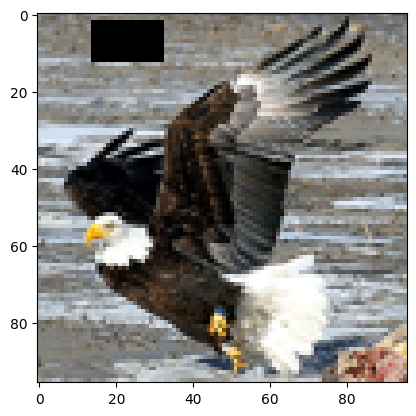

In [55]:
# Test for STL10
batch_size = 64
stl10_test = STL10Masked()
train_loader, test_loader = stl10_test.pack_to_dataloaders(batch_size=batch_size, train_fraction=0.9)
stl10_test.save_dataset(filename="stl10.pt")
plt.imshow(stl10_test.get_masked_image(0).permute((1, 2, 0)))

# Train functions

## Training loop

In [57]:
# Will be done in future
def train_one_epoch(model, train_loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    total = 0
    data = tqdm(train_loader)#enumerate(train_loader), total=int(len(cifar10_test)/train_loader.batch_size))
    for batch in data:
        total += 1
        input, target = batch[0].to(device), batch[1].to(device)
        #print(input.shape)
        #print(target.shape)
        optimizer.zero_grad()
        outputs = model(input).to(device)
        #print(reconstruction.shape)
        loss = loss_fn(outputs, target)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        data.set_postfix({'loss':loss.item()})
    return running_loss / total

# Model training

In [145]:
# model = UNet().to(device)

# epochs = 20

# optimizer = torch.optim.Adam(model.parameters())
# loss_fn = nn.MSELoss()


for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
    print(f'EPOCH: {epoch + 1} out of {epochs}, loss: {round(train_loss, 7)}\n')

100%|██████████| 71/71 [00:30<00:00,  2.36it/s, loss=0.000376]


EPOCH: 1 out of 20, loss: 0.0005098



100%|██████████| 71/71 [00:31<00:00,  2.26it/s, loss=0.000371]


EPOCH: 2 out of 20, loss: 0.0004927



100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.000381]


EPOCH: 3 out of 20, loss: 0.0005047



100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.000407]


EPOCH: 4 out of 20, loss: 0.0005054



100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.000387]


EPOCH: 5 out of 20, loss: 0.0005331



100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.000383]


EPOCH: 6 out of 20, loss: 0.0004758



100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.000361]


EPOCH: 7 out of 20, loss: 0.0004998



100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.000351]


EPOCH: 8 out of 20, loss: 0.0004815



100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.000369]


EPOCH: 9 out of 20, loss: 0.0004996



100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.000343]


EPOCH: 10 out of 20, loss: 0.0004567



100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.000372]


EPOCH: 11 out of 20, loss: 0.0004562



100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.000361]


EPOCH: 12 out of 20, loss: 0.0004761



100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.000336]


EPOCH: 13 out of 20, loss: 0.0004668



100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.00031]


EPOCH: 14 out of 20, loss: 0.0004963



100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.000322]


EPOCH: 15 out of 20, loss: 0.0004229



100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.000365]


EPOCH: 16 out of 20, loss: 0.0004622



100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.000345]


EPOCH: 17 out of 20, loss: 0.0004484



100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.000349]


EPOCH: 18 out of 20, loss: 0.0004976



100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.00039]


EPOCH: 19 out of 20, loss: 0.0004501



100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.000393]

EPOCH: 20 out of 20, loss: 0.0004257



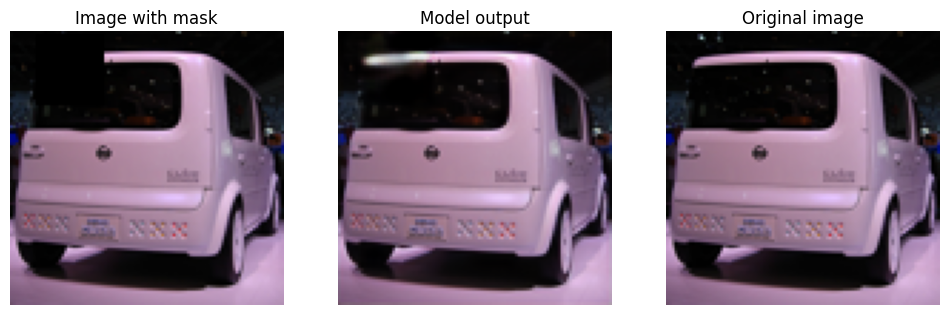

In [151]:
image1, image2, image3 = None, None, None

inx = 7

image1 = stl10_test.get_masked_image(inx).permute((1,2,0))
image3 = stl10_test.get_image(inx).permute((1,2,0))

# Will be done in future
with torch.no_grad():
    model.eval()
    # result = model(img_t.view(1, 3, 32, 32).to(device))
    image2 = model(stl10_test.get_masked_image(inx).view(1, 3, 96, 96).to(device)).cpu()[0].permute(1, 2, 0)
    # print(result[0].shape)
    # plt.imshow(result[0].permute((1,2,0)).cpu())


# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(image1)
axes[0].set_title('Image with mask')

axes[1].imshow(image2)
axes[1].set_title('Model output')

axes[2].imshow(image3)
axes[2].set_title('Original image')

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

# Display the plot
plt.show()

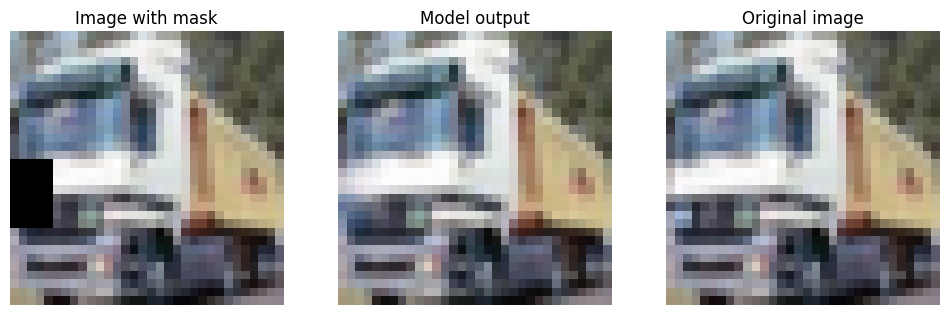

In [23]:
image1, image2, image3 = None, None, None

inx = 1

image1 = cifar10_test.get_masked_image(inx).permute((1,2,0))
image3 = cifar10_test.get_image(inx).permute((1,2,0))

# Will be done in future
with torch.no_grad():
    model.eval()
    # result = model(img_t.view(1, 3, 32, 32).to(device))
    image2 = model(cifar10_test.get_masked_image(inx).view(1, 3, 32, 32).to(device)).cpu()[0].permute(1, 2, 0)
    # print(result[0].shape)
    # plt.imshow(result[0].permute((1,2,0)).cpu())


# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(image1)
axes[0].set_title('Image with mask')

axes[1].imshow(image2)
axes[1].set_title('Model output')

axes[2].imshow(image3)
axes[2].set_title('Original image')

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

# Display the plot
plt.show()